In [3]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [5]:
import os
os.chdir('/data/1122/SGFN')

In [6]:
pwd

'/data/1122/SGFN'

In [ ]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/root/anaconda3/envs/lib/R'

In [8]:
# the number of clusters
n_clusters = 20

In [9]:
dataset = '3.Human_Breast_Cancer'

In [ ]:
# read data
file_fold = '/data/Data1/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
print("空间坐标形状:", adata.obsm['spatial'].shape)
print("空间坐标类型:", adata.obsm['spatial'].dtype)
print("样本数据:", adata.obsm['spatial'][:5])  # 显示前5个点的坐标

空间坐标形状: (3798, 2)
空间坐标类型: int64
样本数据: [[17428 15937]
 [ 6092 18054]
 [16351  7383]
 [ 5278 15202]
 [ 9363 21386]]


In [13]:
import sgfn


/root/anaconda3/envs/graphst/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph constructed!
Building sparse matrix ...
Integrating frequency features...


/data/1122/SGFN/preprocess.py:175: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


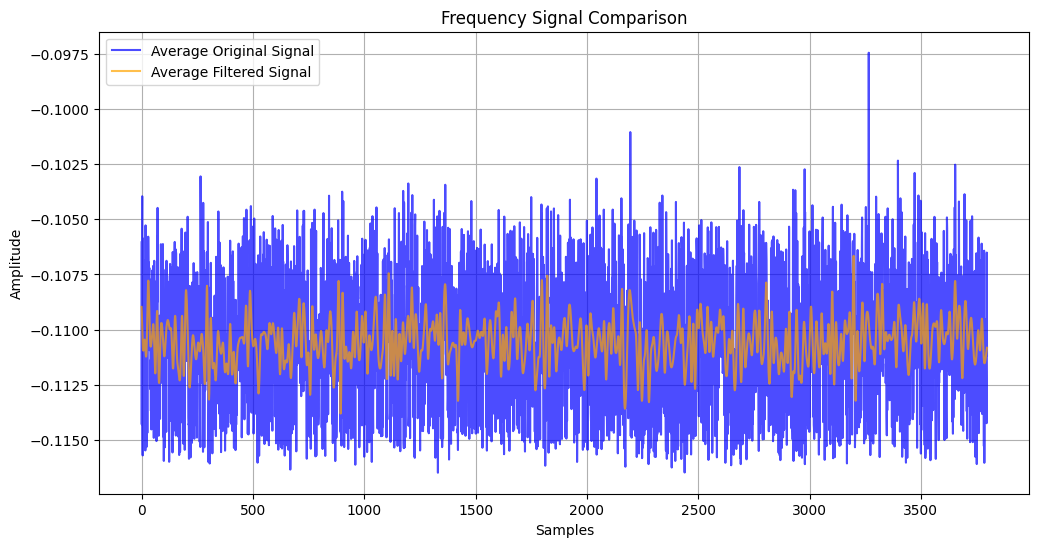

Performing PCA to reduce dimensions...
Features after PCA reduction: torch.Size([3798, 2600])
Frequency feature integration completed in 5.45 seconds
Memory used: 245.11 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved


In [14]:
# define model
model = sgfn.SGFN(adata, device=device,datatype='Stereo',epochs=2000,random_seed=69)

model 

Begin to train ST data ...


Training Progress: 100%|██████████| 2000/2000 [00:36<00:00, 54.40it/s]


Optimization finished for ST data!


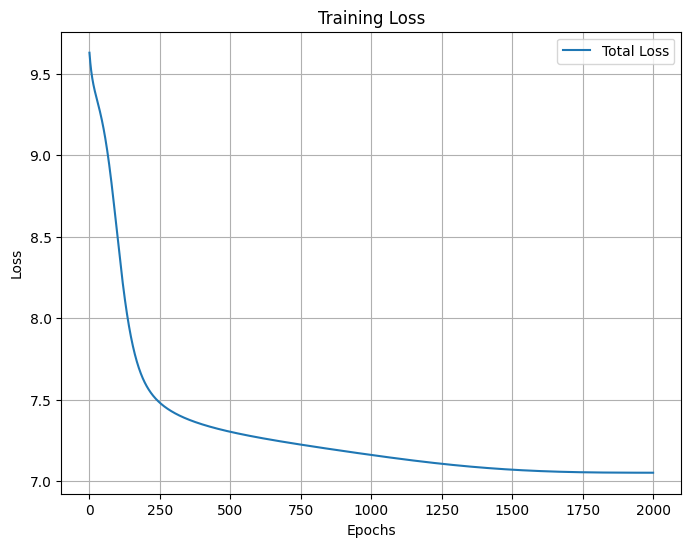


====== TRAINING PERFORMANCE SUMMARY ======
Total training time: 37.33 seconds
Memory used: 1021.72 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved



In [15]:
# train model
adata = model.train()

In [16]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [18]:
# set radius to specify the number of neighbors considered dur ing refinement
radius =25
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [19]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['ground_truth']
adata.obs['ground_truth'] = df_meta_layer.values

In [21]:
adata

View of AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'mclust', 'domain', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'

In [ ]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import (
    homogeneity_score, mutual_info_score, v_measure_score,
    adjusted_mutual_info_score, normalized_mutual_info_score,
    adjusted_rand_score
)

# 过滤掉 NA 节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# 计算 ARI 指标
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

# 计算其他聚类指标

ami = adjusted_mutual_info_score(adata.obs['ground_truth'], adata.obs['domain'])
nmi = normalized_mutual_info_score(adata.obs['ground_truth'], adata.obs['domain'])

adata.uns['AMI'] = ami
adata.uns['NMI'] = nmi

# 输出结果
print('Human_Breast_Cancer')
print('ARI:', ARI)
print('AMI:', ami)
print('NMI:', nmi)

/root/anaconda3/envs/graphst/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Human_Breast_Cancer
ARI: 0.5682394882533539
AMI: 0.6940133766422947
NMI: 0.6995843185767311


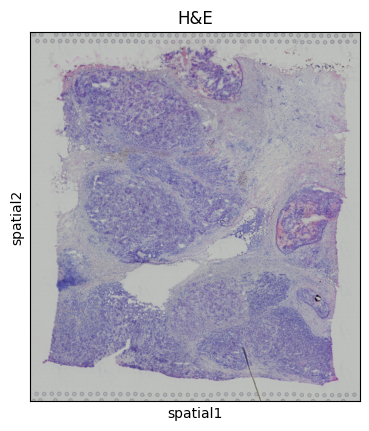

In [ ]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth",],
              title=["H&E",],
              show=True,
              size=1)

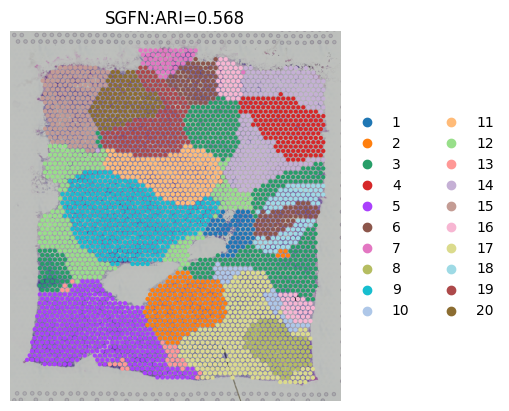

In [23]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=['domain'],
              title=["SGFN:ARI=%.3f"%ARI],
              show=True,
              size=1.3,
              frameon=False,
            #   legend_loc='left'
              )